<a href="https://colab.research.google.com/github/Xw-Jia/2019_SaveYourself_GetOffer/blob/master/%E4%B9%A6%E7%9B%AE%E6%95%B4%E7%90%86/Python%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0/Part2%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E5%AE%9E%E8%B7%B5/%E4%BB%A3%E7%A0%81/6_4_sequence_processing_with_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy==1.16.2



*   字符级的1DConv能够学到单词构词法
*   Keras中的一维卷积是Conv1D-->接受输入(samples, time, features)三维Tensor，卷积窗口是时间轴上的一维窗口(时间轴是输入Tensor的第二个轴)




In [2]:
'''
构建2层Conv1D，做情感分类任务
'''
#准备IMDB数据

from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


In [3]:
'''
一维卷积网络：Conv1D层 + MaxPooling1D层 + 全局池化层/Flatten层---> 将3DTensor输出转成2D输出，才能加Dense层用于分类或回归
一维卷积可以使用更大的卷积窗口
'''
# 训练/评估一个一维卷积NN

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable para

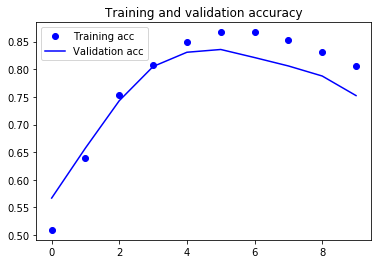

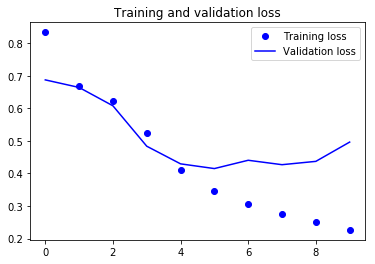

In [4]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [6]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2019-05-06 11:59:53--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.1.227
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.1.227|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  84.5MB/s    in 0.2s    

2019-05-06 11:59:53 (84.5 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [0]:
'''
情感分析中，Conv1D 可以代替 RNN
速度更快，计算代价更低
'''
'''
结合CNN和RNN处理长序列：
1. 在RNN前面，使用CNN将长序列变成短序列 (下采样)
使用这种方法，可以使RNN查看更早的数据，或者分辨率更高的时间序列(减小gen的step参数)
'''
# 模型，两个Conv1D + GRU

# We reuse the following variables defined in the last section:
# float_data, train_gen, val_gen, val_steps

import os
import numpy as np

data_dir = '/content/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [8]:

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 13s 26ms/step - loss: 0.4198 - val_loss: 0.4447
Epoch 2/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3623 - val_loss: 0.4411
Epoch 3/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3364 - val_loss: 0.4432
Epoch 4/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3216 - val_loss: 0.4419
Epoch 5/20
500/500 [==============================] - 12s 23ms/step - loss: 0.3093 - val_loss: 0.4403
Epoch 6/20
500/500 [==============================] - 11s 23ms/step - loss: 0.3013 - val_loss: 0.4574
Epoch 7/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2925 - val_loss: 0.4572
Epoch 8/20
500/500 [==============================] - 12s 25ms/step - loss: 0.2870 - val_loss: 0.4582
Epoch 9/20
500/500 [==============================] - 12s 23ms/step - loss: 0.2808 - val_loss: 0.4563
Epoch 10/20
500/500 [==============================] - 12s 25ms/step - loss: 0.276

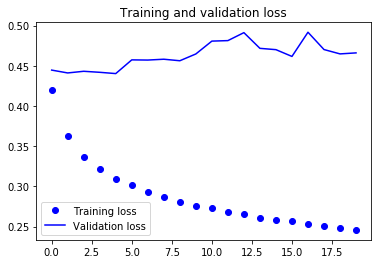

In [9]:

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

结果来看，CNN+GRU不如GRU+Dropout

但是，速度快很多，因为CNN的存在使RNN需要处理的序列变短

In [0]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720  # Unchanged
delay = 144 # Unchanged

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [12]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
500/500 [==============================] - 73s 147ms/step - loss: 0.3357 - val_loss: 0.2858
Epoch 2/10
500/500 [===============

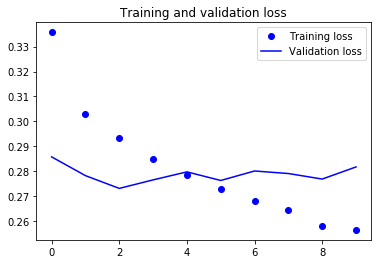

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()